# ABAQUS Test on Capped-Conical Indentor into Plane

## Imports

In [ ]:
# -------------------------------------- Possible modules to pip instal-------------------------------------------------
# import sys
# !{sys.executable} -m pip install pyabaqus==2022
# !{sys.executable} -m pip install paramiko

In [43]:
# --------------------------------------------------System Imports-----------------------------------------------------
import os
import sys
import time
import subprocess

# -----------------------------------------------Server commands--------------------------------------------------------
import paramiko
from scp import SCPClient
host = "128.40.163.27"
port = 22
username = "giblnbrnhm_j"
password = "axenub13"

# ---------------------------------------------Mathematical/Plotting Imports--------------------------------------------
# Importing relevant maths and graphing modules
import numpy as np 
import math
from numpy import random   
from random import randrange
from scipy.optimize import curve_fit

# Plotting import and settinngs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator

linewidth = 11.69/2 # inch

plt.rcParams["figure.figsize"] = (linewidth/3, (1/1.61)*linewidth/3)
plt.rcParams['figure.dpi'] = 256
plt.rcParams['font.size'] = 16
plt.rcParams["font.family"] = "Times New Roman"


plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

3.9.16


# Abaqus Simulation

## Main Abaqus Script Radius/Depth Variation

In [4]:
%%writefile AFMtestConical_Plane.py

# ----------------------------------------------Load Modules-----------------------------------------------------------
import numpy as np 
from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import *
from part import *
from material import *
from section import *
from assembly import *
from interaction import *
from mesh import *
from visualization import *
import visualization
import odbAccess
from connectorBehavior import *
import cProfile, pstats, io
import regionToolset
#from abaqus import getInput
executeOnCaeStartup()

# ----------------------------------------------Import variables------------------------------------------------------
# depth = [3, 5 ,10,15,20,30,40,50,60,70,80,90,100]
depth = [3, 5 ,10,15,20,30,40,50,60,75]

# Cone variables
R_indentor = 1
theta_degrees = 20
theta = theta_degrees*(np.pi/180)
tip_length = 25

# Intercept of spherical and conical section of indentor (Tangent point) 
x_int, y_int = R_indentor*np.cos(theta), -R_indentor*np.sin(theta)

# Total radius/ footprint of indentor/ top coordinates
x_top, y_top = tip_length*np.tan(theta), tip_length

# Simulation variables
timePeriod = 2.5
timeInterval = 0.1
N = int(timePeriod/ timeInterval)

# Arrays for data
RF = np.zeros([len(depth),N+1])
U2 = np.zeros([len(depth),N+1])


#  -------------------------------------------------Model-------------------------------------------------------------
for i, r in enumerate(depth):
    modelName = jobName = 'AFMtestConical_Plane-'+str(i)
    model = mdb.Model(name=modelName)


    # ------------------------------------------------Set Parts----------------------------------------------------------- 
    # Create Indentor part
    model.ConstrainedSketch(name = 'indentor', sheetSize=1.0) 
    model.sketches['indentor'].ConstructionLine(point1=(0,-R_indentor),point2=(0,y_top))
    model.sketches['indentor'].ArcByCenterEnds(center=(0,0), point1=(x_int,y_int), point2=(0,-R_indentor), 
                                               direction = CLOCKWISE)
    model.sketches['indentor'].Line(point1=(x_int,y_int), point2=(x_top,y_top))
    model.sketches['indentor'].Line(point1=(0,y_top), point2=(x_top,y_top))
    
    model.Part(name='indentor', dimensionality=AXISYMMETRIC, type= DISCRETE_RIGID_SURFACE)
    model.parts['indentor'].BaseWire(sketch = model.sketches['indentor'])

    # Create plane part 
    model.ConstrainedSketch(name = 'plane', sheetSize=1.0)   
    model.sketches['plane'].ConstructionLine(point1=(0,r),point2=(0,-r))
    model.sketches['plane'].rectangle(point1=(0,0),point2=(r,-r))
    model.Part(name='plane', dimensionality=AXISYMMETRIC, type=DEFORMABLE_BODY)
    model.parts['plane'].BaseShell(sketch = model.sketches['plane'])

    # ----------------------------------------------Set Geometry----------------------------------------------------------
    # Create geometric sets for referencing
    model.parts['indentor'].Set(edges= model.parts['indentor'].edges, name='indentor_edges')   
    model.parts['plane'].Set(faces= model.parts['plane'].faces, name='plane_edges')
      
    model.parts['plane'].Set(name='plane_surface_bottom', 
                             edges = model.parts['plane'].edges.getSequenceFromMask(mask=('[#4]', ), ) )
    model.parts['plane'].Set(name='plane_surface_side', 
                             edges = model.parts['plane'].edges.getSequenceFromMask(mask=('[#8 ]', ), ))
    
    # Create gemoetric surface for contact
    model.parts['plane'].Surface(name='plane_surface_top', 
                                 side1Edges = model.parts['plane'].edges.getSequenceFromMask(mask=('[#1]', ), ) ) 

    model.parts['indentor'].Surface(name='indentor_surface', 
                                    side1Edges = model.parts['indentor'].edges.getSequenceFromMask( mask=('[#1]',), ),
                                    side2Edges = model.parts['indentor'].edges.getSequenceFromMask( mask=('[#2]',), )   )

    # Create reference points
    point = model.parts['indentor'].ReferencePoint((0, 0, 0))
    model.parts['indentor'].Set(referencePoints = (model.parts['indentor'].referencePoints[point.id],),
                                name= 'indentor_centre')
    point = model.parts['plane'].ReferencePoint((0, -r, 0))
    model.parts['plane'].Set(referencePoints = (model.parts['plane'].referencePoints[point.id],), name='plane_base')

    model.rootAssembly.regenerate()


    # -----------------------------------------------Set Properties--------------------------------------------------------
    # Assign materials
    model.Material(name='plane_material')
    model.materials['plane_material'].Elastic(table=((1000, 0.3), ))
    model.HomogeneousSolidSection(name='section', material='plane_material', thickness=None)
    model.parts['plane'].SectionAssignment( region = model.parts['plane'].sets['plane_edges'], sectionName='section')


    # ----------------------------------------------Set Assembly----------------------------------------------------------
    model.rootAssembly.Instance(name='plane', part = model.parts['plane'],dependent=ON)
    model.rootAssembly.Instance(name='indentor', part = model.parts['indentor'], dependent=ON)
    model.rootAssembly.translate(instanceList = ('indentor',) , vector = (0,R_indentor,0) )
    model.rootAssembly.DatumCsysByDefault(CARTESIAN)


    # ------------------------------------------------Set Steps-----------------------------------------------------------
    step = model.StaticStep(name='Step-1', previous='Initial', description='', timePeriod=timePeriod, 
                            timeIncrementationMethod=AUTOMATIC, maxNumInc=int(1e5), 
                            initialInc=1.0, minInc=1e-15, maxInc=1)
    field = model.FieldOutputRequest('F-Output-1', createStepName='Step-1', variables=('RF', 'TF', 'U'), 
                                     timeInterval = timeInterval)
    
    model.steps['Step-1'].control.setValues(allowPropagation=OFF, resetDefaultValues=OFF, 
                              timeIncrementation=(4.0, 8.0, 9.0, 16.0, 10.0, 4.0, 12.0, 25.0, 6.0, 3.0, 50.0))


    # ----------------------------------------------Set Interactions------------------------------------------------------
    model.ContactProperty(name = 'Contact Properties')
    model.interactionProperties['Contact Properties'].TangentialBehavior(formulation =ROUGH)
    model.interactionProperties['Contact Properties'].NormalBehavior(pressureOverclosure=HARD)

    model.RigidBody(name= 'indentor_constraint', 
                    bodyRegion = model.rootAssembly.instances['indentor'].sets['indentor_edges'],
                    refPointRegion = model.rootAssembly.instances['indentor'].sets['indentor_centre'])
        
    model.SurfaceToSurfaceContactStd(name    = 'surface-indentor', 
                                     createStepName = 'Initial', 
                                     master = model.rootAssembly.instances['indentor'].surfaces['indentor_surface'], 
                                     slave  = model.rootAssembly.instances['plane'].surfaces['plane_surface_top'],
                                     interactionProperty = 'Contact Properties', 
                                     sliding = FINITE)
    

    # -----------------------------------------------Set Loads------------------------------------------------------------
    # Create surface boundary conditions
    model.DisplacementBC(name='Base-BC',createStepName='Initial', 
                         region= model.rootAssembly.instances['plane'].sets['plane_surface_bottom'], 
                         u1=SET, u2=SET, ur3= SET)

    # Create indentor boundary conditions
    model.DisplacementBC(name='Indentor-U',createStepName='Step-1',
                         region= model.rootAssembly.instances['indentor'].sets['indentor_centre'], 
                         u1=SET, u2=-3, ur3 = SET )


    # ------------------------------------------------Set Mesh------------------------------------------------------------
    # Assign an 'plane' type to the part instance- seed and generate
    model.rootAssembly.regenerate()
    model.parts['plane'].seedPart(size = 0.5)    
    model.parts['plane'].setElementType(model.rootAssembly.instances['plane'].sets['plane_edges'], 
                                        elemTypes =(mesh.ElemType(elemCode=TRI,secondOrderAccuracy = ON),) )
    model.parts['plane'].setMeshControls(regions= model.rootAssembly.instances['plane'].sets['plane_edges'].vertices,
                                         elemShape=TRI, technique=FREE)
    model.parts['plane'].generateMesh()

    model.parts['indentor'].seedPart(size = 0.3)
    model.parts['indentor'].seedEdgeBySize(edges=model.parts['indentor'].edges.getSequenceFromMask(mask=('[#1]', ), ),
                                           size=0.1, constraint=FINER)
    model.parts['indentor'].generateMesh()


    # ----------------------------------------------Set Submission--------------------------------------------------------
    # Create an analysis job for the model and submit it.
    job = mdb.Job(name=jobName, model=modelName, description='AFM plane')
    job.writeInput()
    job.submit()
    job.waitForCompletion()

    # --------------------------------------------Set Data extraction----------------------------------------------------
    
    # Opening the odb
    odb    = session.openOdb(jobName +'.odb', readOnly=True)
    region = odb.rootAssembly.nodeSets.values()[1]

    # Extracting Step 1, this analysis only had one step
    step1 = odb.steps.values()[0]
        
    j,k = 0, 0 
    # Creating a for loop to iterate through all frames in the step
    for x in odb.steps[step1.name].frames:
        # Reading stress and strain data from the model 
        fieldRF = x.fieldOutputs['RF'].getSubset(region= region)
        fieldU  = x.fieldOutputs['U'].getSubset(region= region)    
        
        # Storing Stress and strain values for the current frame
        for rf in fieldRF.values:
            RF[i,j] = rf.data[1]
            j+=1
            
        for u in fieldU.values:
            U2[i,k] = u.data[1] 
            k+=1    
        
# Writing to a .csv file
np.savetxt("U2_Results.csv", U2 , delimiter=",")
np.savetxt("RF_Results.csv", RF , delimiter=",")

# Close the odb
odb.close()

mdb.saveAs('AFMtestCapped-Plane.cae')

Overwriting AFMtestConical_Plane.py


## Submission

In [24]:
# !abaqus fetch job=AFMtestConical_Plane
# !abaqus cae -noGUI AFMtestConical_Plane.py

In [5]:
t0 = time.time()

localPath = os.getcwd()
remotePath = '/home/giblnbrnhm_j@MECHENG2012/ABAQUS/Capped-Plane_Indentation/'
script = 'AFMtestCapped_Plane.py'
command  = 'cd ' + remotePath + '\n /opt/abaqus2018/abq2018 cae -noGUI ' + script + ' & \n'

ssh_client = paramiko.SSHClient()
ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh_client.connect(host, port, username, password)

# Make working directory
stdin, stdout, stderr = ssh_client.exec_command('mkdir ' + remotePath)
lines = stdout.readlines()
print(lines)

# SCPCLient Uploading content into remote directory
scp_client = SCPClient(ssh_client.get_transport())
scp_client.put(script, recursive=True, remote_path=remotePath)
scp_client.close()

# Execute abaqus command
stdin, stdout, stderr = ssh_client.exec_command(command)
lines = stdout.readlines()
print(lines)

ssh_client.close()

t1 = time.time()
print(t1-t0)

[]
[]
1265.3590128421783


In [6]:
t0 = time.time()

localPath = os.getcwd()
remotePath = '/home/giblnbrnhm_j@MECHENG2012/ABAQUS/Capped-Plane_Indentation/'
script = 'AFMtestCapped_Plane.py'

ssh_client =paramiko.SSHClient()
ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh_client.connect(host, port, username, password)

ftp_client=ssh_client.open_sftp()
ftp_client.get(remotePath+'U2_Results.csv', localPath+'\\U2_Results.csv')   
ftp_client.get(remotePath+'RF_Results.csv', localPath+'\\RF_Results.csv')   
ftp_client.close()
ssh_client.close()

t1 = time.time()
print(t1-t0) 

2.6150848865509033


# Data Processing

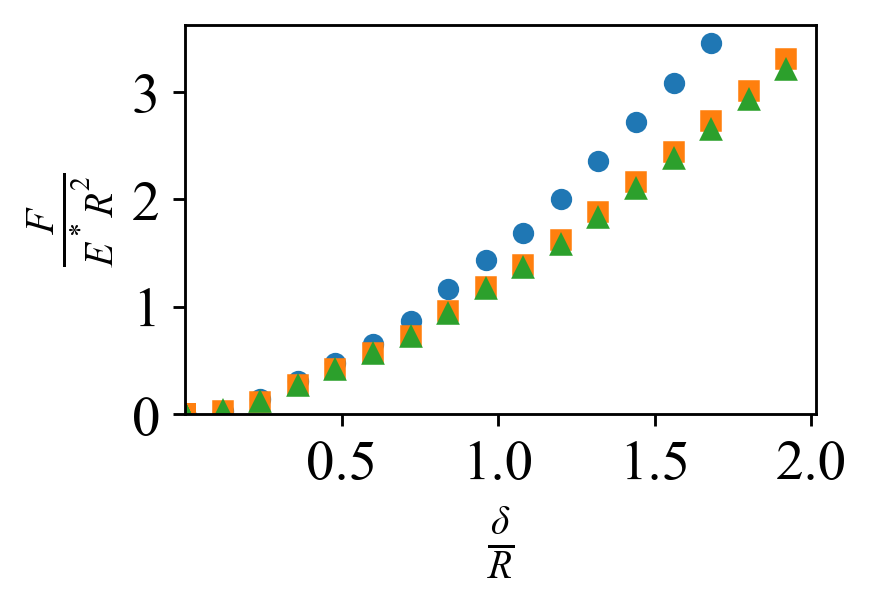

In [42]:
# --------------------------------------------------Variables-----------------------------------------------------
U2 = np.array(np.loadtxt('U2_Results.csv', delimiter=","))
RF = np.array(np.loadtxt('RF_Results.csv', delimiter=","))

# Set force cut off to fit at set maximum indentation force as apposed to depth
RFmax = np.max(RF, axis=0).min()
RF = np.ma.masked_less_equal(RF, RFmax)
U2 = np.ma.masked_array(U2, mask = np.ma.getmask(RF))

depth = np.array([3, 5 ,10,15,20,30,40,50,60,75])

R_indentor = 1
theta_degrees = 20
theta = theta_degrees*(np.pi/180)

v = 0.3
E = 1000
E_eff = E/(1-v**2)

markers = ['o','s','^','H','D','X'] 

# --------------------------------------------------Plot 1-----------------------------------------------------
fig, ax = plt.subplots(1,1)
for i in range(0,len(U2),4):
    ax.plot(-U2[i]/R_indentor, -RF[i]/(E_eff*R_indentor**2), markers[int(i/4)], ms = 5, label = r'$\frac{h}{R}$='+str(depth[i]/R_indentor))
ax.set_xlabel(r'$\frac{\delta}{R}$')
ax.set_ylabel(r'$\frac{F}{E^*R^2}$')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
# ax.legend(frameon=False)

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=4)
plt.show()

# Parameter Fit

## Spherical Indentor (Hertz)

$$F(\delta) = \frac{4}{3}\frac{E}{(1-\nu^2)}R_{eff}^{1/2}\delta^{3/2}$$

### For Flat Surface 
$$R_{eff} = R_{Indentor}$$

### Spherical Surface

$$\frac{1}{R_{eff}} = \frac{1}{R_{plane}}+\frac{1}{R_{Indentor}}$$

In [29]:
E_hertz = np.zeros(len(depth))
err_hertz =  np.zeros(len(depth))

x = np.linspace(0,2.5,40)

for i, r in enumerate(depth):
    def F_Hertz(U,E):
        return (4/3) * (E/(1-v**2)) * np.sqrt(R_indentor) * U**(3/2)
    
    u2, rf = abs(U2[i]),abs(RF[i])
    popt, pcov = curve_fit(F_Hertz, u2, rf)
    
    E_hertz[i] = popt
    err_hertz[i]= pcov

In [30]:
# fig, ax = plt.subplots(len(depth), 1, figsize = (20,40))
# for i, r in enumerate(depth):
#     ax[i].plot(u2, rf, 'x', color = 'b', label = 'Cylinder radius/ depth r='+str(r))
#     ax[i].plot(x, F_Hertz(x,popt), '-', color = 'k', label = 'Hertz fit r='+str(r))
#     ax[i].plot(x, F_Hertz(x,popt+pcov[0]), ':', color = 'g', label = 'Hertz Overfit r='+str(r))
#     ax[i].plot(x, F_Hertz(x,popt-pcov[0]), ':', color = 'r', label = 'Hertz Underfit r='+str(r))
    
#     ax[i].set_xlabel('Indentation depth')
#     ax[i].set_ylabel('Force')
#     ax[i].set_title('Conical Indentor Force curve variation')
#     ax[i].legend()
    
# plt.subplots_adjust(hspace = 0.5)
# plt.show()

## Conical Indentor (Sneddon)

#### Flat Surface
$$F(\delta) = \frac{2}{\pi}\frac{E}{(1-\nu^2)}tan(\alpha)\delta^{2}$$

#### Spherical Surface
$$F(\delta) = \frac{2}{\pi}\frac{E}{(1-\nu^2)} \cdot tan(\alpha)U^{2} \cdot f\left(\frac{\delta}{2R_{Surface}}\right)$$

$$ f\left(\frac{\delta}{2R_{Surface}}\right) = 1+ \gamma \left(\frac{\delta}{2R_{Surface}}\right) $$

$$\gamma = −5.103\nu^2 − 13.99\nu + 13.53 $$

In [31]:
E_Sneddon = np.zeros(len(depth))
err_Sneddon =  np.zeros(len(depth))

x = np.linspace(0,2.5,40)
for i, r in enumerate(depth):
    def F_Sneddon(U,E):
        return (2/np.pi) * (E/(1-v**2))* np.tan(theta) * U**(2) *(1+(-5.103*v**2-13.99*v+13.53)*(U/2*r)) 
        # return (2/np.pi) * (E/(1-v**2))* np.tan(theta) * U**(2)
    
    u2, rf = abs(U2[i]),abs(RF[i])
    popt, pcov = curve_fit(F_Sneddon, u2[7:], rf[7:])
    
    E_Sneddon[i] = popt
    err_Sneddon[i]= pcov

In [32]:
# fig, ax = plt.subplots(len(depth), 1, figsize = (20,40))
# for i, r in enumerate(depth):    
#     ax[i].plot(u2, rf, 'x', color = 'b', label = 'Cylinder radius/ depth r='+str(r))
#     ax[i].plot(x, F_Sneddon(x,popt), '-', color = 'k', label = 'Sneddon fit r='+str(r))
#     ax[i].plot(x, F_Sneddon(x,popt+pcov[0]), ':', color = 'g', label = 'Sneddon Overfit r='+str(r))
#     ax[i].plot(x, F_Sneddon(x,popt-pcov[0]), ':', color = 'r', label = 'Sneddon Underfit r='+str(r))
    
#     ax[i].set_xlabel('Indentation depth')
#     ax[i].set_ylabel('Force')
#     ax[i].set_title('Conical Indentor Force curve variation')
#     ax[i].legend()
    
# plt.subplots_adjust(hspace = 0.5)
# plt.show()

## Spherical Indentor Dimitriadis Model:
https://doi.org/10.1016/S0006-3495(02)75620-8

$$F_{Dimitriadis}(\delta) = \frac{4}{3}\frac{E_{2}}{(1-\nu_{2}^2)}R_{12}^{1/2}\delta^{3/2} \left[ 1 - \frac{2\alpha_0}{\pi}\chi + \left(\frac{2\alpha_0}{\pi}\chi\right)^2 -  \left(\frac{2\alpha_0}{\pi}\chi\right)^3 +  \left(\frac{2\alpha_0}{\pi}\chi\right)^4 -\frac{16}{\pi^2}\beta_0 \left( \frac{2\pi}{15}  - \frac{3}{5}\alpha_0\chi \right)\chi^3   \right]$$

$$F_{Dimitriadis} = F_{12}+F_{32}$$
$$\delta = \delta_{12}-\delta^*_{32}$$
$$ \frac{1}{R_{12}} = \frac{1}{R_{1}} + \frac{1}{R_{2}} $$

$$\chi = \frac{\sqrt{R_{12}\delta}}{h}$$
$$\alpha_0 = -0.347\frac{3-2\nu_{2}}{1-\nu_{2}}$$
$$\beta_0 = 0.056\frac{5-2\nu_{2}}{1-\nu_{2}}$$

In [35]:
E_dim = np.zeros(len(depth))
err_dim =  np.zeros(len(depth))

x = np.linspace(0,2.5,40)

for i, r in enumerate(depth):
    def F_Dim(U,E):
        alpha = -0.347*(3-2*v)/(1-v)
        beta = 0.056*(5-2*v)/(1-v)
        R_eff = R_indentor #1/(1/r +1/R_indentor)
        chi = np.sqrt(U*R_eff)/(2*r)
        return (4/3) * (E/(1-v**2)) * np.sqrt(R_eff) * U**(3/2)*(1-(2*alpha*chi/np.pi)+(2*alpha*chi/np.pi)**2-(2*alpha*chi/np.pi)**3+(2*alpha*chi/np.pi)**4 - beta*(16/np.pi**2)*(2*np.pi/15-3/5*alpha*chi)*chi**3)
    
    u2, rf = abs(U2[i]), abs(RF[i])
    popt, pcov = curve_fit(F_Dim, u2, rf)
    
    E_dim[i] = popt
    err_dim[i]= pcov

In [36]:
    
# fig, ax = plt.subplots(len(depth), 1, figsize = (20,40))
# for i, r in enumerate(depth):    
#     ax[i].plot(u2, rf, 'x', color = 'b', label = 'Cylinder radius/ depth r='+str(r))
#     ax[i].plot(x, F_Dim(x,popt), '-', color = 'k', label = 'Dimitriadis fit r='+str(r))
#     ax[i].plot(x, F_Dim(x,popt+pcov[0]), ':', color = 'g', label = 'Dimitriadis Overfit r='+str(r))
#     ax[i].plot(x, F_Dim(x,popt-pcov[0]), ':', color = 'r', label = 'Dimitriadis Underfit r='+str(r))
    
#     ax[i].set_xlabel('Indentation depth')
#     ax[i].set_ylabel('Force')
#     ax[i].set_title('Conical Indentor Force curve variation')
#     ax[i].legend()
    
# plt.subplots_adjust(hspace = 0.5)
# plt.show()

# Comparision

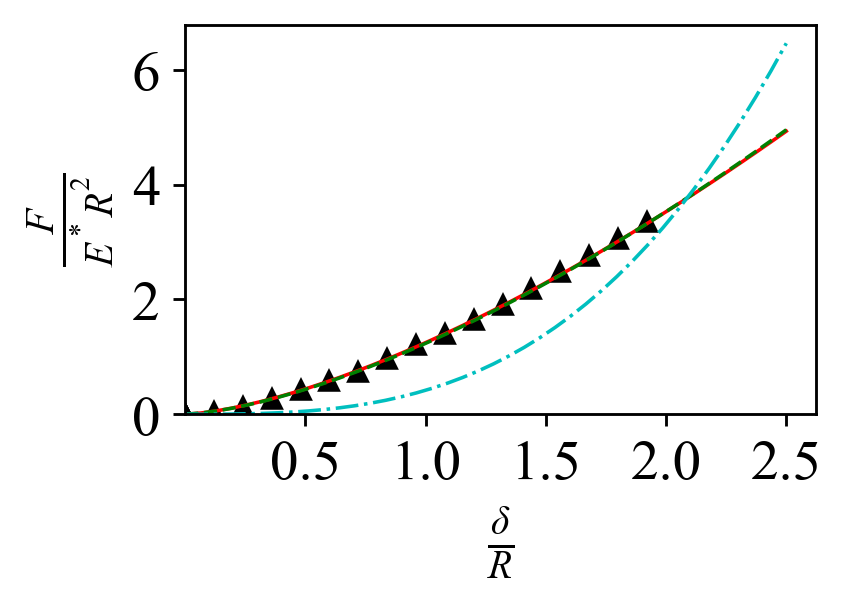

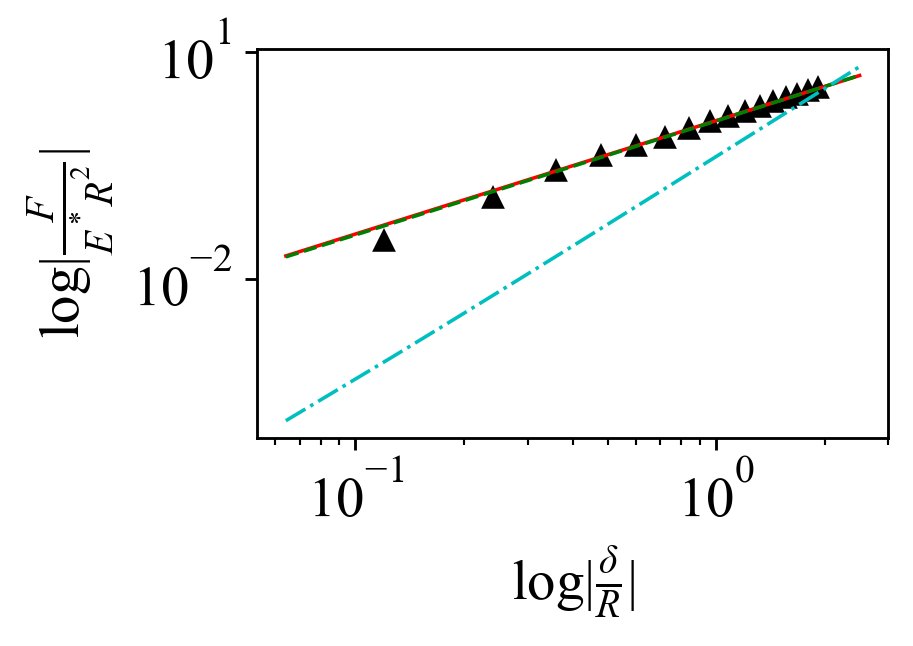

In [44]:
k=3
r = depth[k]

x = np.linspace(0,2.5,40)
u2, rf = abs(U2[k]), abs(RF[k])

# --------------------------------------------------Plot 1-----------------------------------------------------
fig, ax = plt.subplots(1, 1)

ax.plot(u2/R_indentor, rf/(E_eff*R_indentor**2), '^', ms = 5, color = 'k', label = 'Data')
ax.plot(x/R_indentor, F_Hertz(x,E_hertz[k])/(E_eff*R_indentor**2),     '-', lw = 1, color = 'r', label = 'Hertz')
ax.plot(x/R_indentor, F_Dim(x,E_dim[k])/(E_eff*R_indentor**2),        '--', lw = 1, color = 'g', label = 'Dimitriadis')
ax.plot(x/R_indentor, F_Sneddon(x,E_Sneddon[k])/(E_eff*R_indentor**2), '-.', lw = 1, color = 'c', label = 'Sneddon')

ax.set_xlabel(r'$\frac{\delta}{R}$')
ax.set_ylabel(r'$\frac{F}{E^*R^2}$')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
# ax.legend(frameon=False, loc = [0,0.42])

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=4)
plt.show()


# --------------------------------------------------Plot 2-----------------------------------------------------
fig, ax = plt.subplots(1, 1)
ax.plot((u2[1:]/R_indentor), (rf[1:]/(E_eff*R_indentor**2)), '^', ms = 5, color = 'k', label = 'Data')

ax.plot((x[1:]/R_indentor), (F_Hertz(x,E_hertz[k])[1:]/(E_eff*R_indentor**2)),     '-', lw = 1, color = 'r',  label = 'Hertz')
ax.plot((x[1:]/R_indentor), (F_Dim(x,E_dim[k])[1:]/(E_eff*R_indentor**2)),        '--', lw = 1, color = 'g',  label = 'Dimitriadis')
ax.plot((x[1:]/R_indentor), (F_Sneddon(x,E_Sneddon[k])[1:]/(E_eff*R_indentor**2)), '-.', lw = 1, color = 'c',  label = 'Sneddon') 

ax.set_xlabel(r'log|$\frac{\delta}{R}$|')
ax.set_ylabel(r'log|$\frac{F}{E^*R^2}$|')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.legend(frameon=False, loc = [0.35,0])
    
plt.show()

# Youngs Modulus

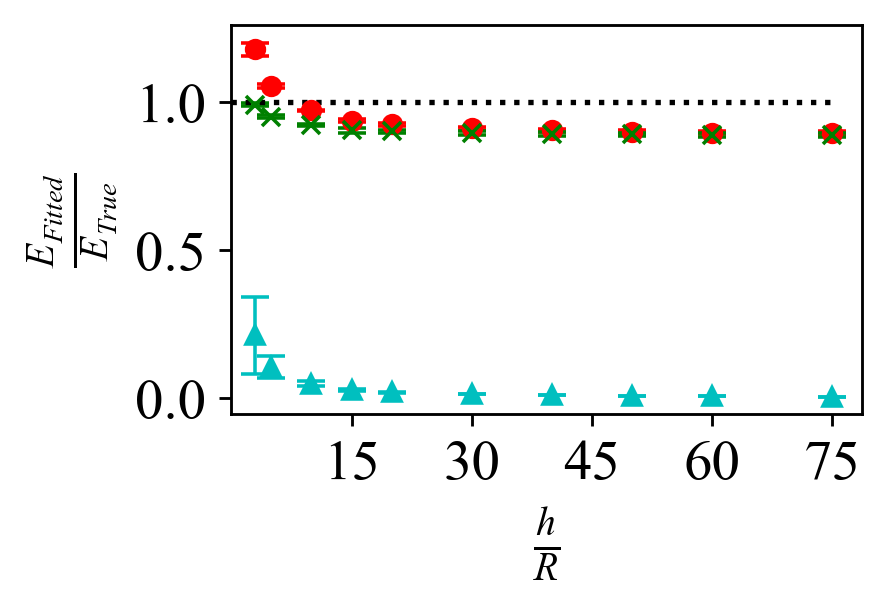

In [41]:
# --------------------------------------------------Plot 1-----------------------------------------------------
fig, ax = plt.subplots(1,1)
ax.errorbar(depth/R_indentor, E_hertz/E,   yerr=err_hertz/E,   fmt='o', color = 'r', ms = 5, lw = 1, capsize=4, label = 'Hertz')
ax.errorbar(depth/R_indentor, E_dim/E,     yerr=err_dim/E,     fmt='x', color = 'g', ms = 5, lw = 1, capsize=4, label = 'Dimitriadis' )
ax.errorbar(depth/R_indentor, E_Sneddon/E, yerr=err_Sneddon/E, fmt='^', color = 'c', ms = 5, lw = 1, capsize=4, label = 'Sneddon' )

ax.plot(np.linspace(0,depth[-1],10)/R_indentor, np.ones(10), ':', color = 'k')

ax.set_xlabel(r'$\frac{h}{R}$')
ax.set_ylabel(r'$\frac{E_{Fitted}}{E_{True}}}$') 
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])
# ax.legend(frameon=False, loc = [0.25,0.15])

plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=4)
plt.show()